# Tutorial 11-5: Taming the Beast – "Wasserstein GAN (WGAN-GP)"

**Course:** CSEN 342: Deep Learning  
**Topic:** WGAN, Gradient Penalty, and Training Stability

## Objective
Standard GANs (like the DCGAN from Tutorial 35) are notoriously unstable. They suffer from:
1.  **Mode Collapse:** The generator produces only one specific image (Slide 25).
2.  **Vanishing Gradients:** If the discriminator is too good, the generator learns nothing (Slide 27).

**The Solution:** The **Wasserstein GAN (WGAN)** changes the objective function to measure the "Earth Mover's Distance" between the real and fake distributions. To make this mathematically valid, the Discriminator (now called a **Critic**) must satisfy the **Lipschitz Constraint**.

In this tutorial, we will implement **WGAN-GP** (WGAN with Gradient Penalty), the modern standard for stable GAN training.

We will use **Fashion-MNIST**.

---

## Part 1: Architecture Changes

**The Generator** remains mostly the same as DCGAN.

**The Critic (Discriminator)** needs specific changes for WGAN-GP:
1.  **Output:** No `Sigmoid` layer. We want a raw score ($-\infty$ to $+\infty$), not a probability.
2.  **Normalization:** No `BatchNorm`. Batch Norm creates dependencies between samples in a batch, which invalidates the gradient penalty calculation. We use `LayerNorm` or no normalization.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
import matplotlib.pyplot as plt
import numpy as np
import os

# Config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 64
image_size = 28
channels = 1
z_dim = 100
lambda_gp = 10  # Gradient penalty weight (standard value from paper)

# 1. Load Fashion-MNIST
data_root = '../data'
os.makedirs(data_root, exist_ok=True)

transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5]) # Normalize to [-1, 1]
])

# Download
try:
    dataset = torchvision.datasets.FashionMNIST(root=data_root, train=True, download=True, transform=transform)
except:
    print("Download failed, checking for local file...")

dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, drop_last=True)

# 2. The Generator (Standard DCGAN-style)
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # Input: z_dim x 1 x 1
            nn.ConvTranspose2d(z_dim, 128, 7, 1, 0, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 128 x 7 x 7
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 64 x 14 x 14
            nn.ConvTranspose2d(64, channels, 4, 2, 1, bias=False),
            nn.Tanh() # Output: 1 x 28 x 28, Range [-1, 1]
        )

    def forward(self, input):
        return self.main(input)

# 3. The Critic (WGAN-GP style)
class Critic(nn.Module):
    def __init__(self):
        super(Critic, self).__init__()
        self.main = nn.Sequential(
            # Input: 1 x 28 x 28
            nn.Conv2d(channels, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # NO Batch Norm allowed here!
            
            # 64 x 14 x 14
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(128, affine=True), # Using InstanceNorm instead of BatchNorm
            nn.LeakyReLU(0.2, inplace=True),
            
            # 128 x 7 x 7
            nn.Conv2d(128, 1, 7, 1, 0, bias=False),
            # Output: 1 x 1 x 1 (Raw Score)
            # NO Sigmoid here!
        )

    def forward(self, input):
        return self.main(input).view(-1, 1)

gen = Generator().to(device)
critic = Critic().to(device)

print("Models initialized for WGAN-GP.")

Models initialized for WGAN-GP.


---

## Part 2: The Gradient Penalty

To enforce the **Lipschitz Constraint** (which ensures the Critic doesn't grow too fast), we penalize the model if the norm of its gradients moves away from 1.

**The Formula (Slide 29):**
$$ GP = \lambda \mathbb{E}_{\hat{x}} [(|| \nabla_{\hat{x}} D(\hat{x}) ||_2 - 1)^2] $$

Where $\hat{x}$ is a random interpolation between real ($x$) and fake ($\tilde{x}$) images.

In [2]:
def compute_gradient_penalty(critic, real_samples, fake_samples):
    """Calculates the gradient penalty loss for WGAN GP"""
    # Random weight term for interpolation between real and fake samples
    alpha = torch.rand((real_samples.size(0), 1, 1, 1), device=device)
    
    # Get random interpolation between real and fake samples
    # hat_x
    interpolates = (alpha * real_samples + (1 - alpha) * fake_samples).requires_grad_(True)
    
    d_interpolates = critic(interpolates)
    
    # Get gradient w.r.t. interpolates
    fake = torch.ones((real_samples.size(0), 1), device=device)
    
    gradients = torch.autograd.grad(
        outputs=d_interpolates,
        inputs=interpolates,
        grad_outputs=fake,
        create_graph=True,
        retain_graph=True,
        only_inputs=True,
    )[0]
    
    # Flatten gradients to (Batch, -1)
    gradients = gradients.view(gradients.size(0), -1)
    
    # L2 Norm
    gradient_norm = gradients.norm(2, dim=1)
    
    # Penalty: distance from 1
    gradient_penalty = ((gradient_norm - 1) ** 2).mean()
    
    return gradient_penalty

---

## Part 3: The Training Loop

WGAN training differs from standard GANs:
1.  **Multiple Critic Steps:** We train the Critic $n_{critic}$ times (usually 5) for every 1 Generator step. This ensures the Wasserstein distance estimate is accurate.
2.  **Optimizers:** Usually use Adam with $\beta_1 = 0.0$ and $\beta_2 = 0.9$ (standard for WGAN).
3.  **Loss:**
    * Critic Loss: $D(G(z)) - D(x) + \lambda GP$ (Maximize gap between Real and Fake scores).
    * Generator Loss: $-D(G(z))$ (Maximize Critic's score for Fake images).

In [3]:
# Optimizers (Note beta1=0.0)
opt_gen = optim.Adam(gen.parameters(), lr=0.0001, betas=(0.0, 0.9))
opt_critic = optim.Adam(critic.parameters(), lr=0.0001, betas=(0.0, 0.9))

fixed_noise = torch.randn(64, z_dim, 1, 1, device=device)
n_critic = 5
epochs = 5

gen.train()
critic.train()

print("Starting WGAN-GP Training...")

for epoch in range(epochs):
    for i, (real_imgs, _) in enumerate(dataloader):
        real_imgs = real_imgs.to(device)
        cur_batch_size = real_imgs.shape[0]

        # ---------------------
        #  Train Critic
        # ---------------------
        for _ in range(n_critic):
            opt_critic.zero_grad()
            
            # Generate fake images
            noise = torch.randn(cur_batch_size, z_dim, 1, 1, device=device)
            fake_imgs = gen(noise)
            
            # Critic Scores
            real_validity = critic(real_imgs)
            fake_validity = critic(fake_imgs.detach())
            
            # Gradient Penalty
            gp = compute_gradient_penalty(critic, real_imgs, fake_imgs.detach())
            
            # Adversarial Loss (Wasserstein)
            # Goal: Maximize (Real - Fake) -> Minimize (Fake - Real)
            d_loss = -torch.mean(real_validity) + torch.mean(fake_validity) + lambda_gp * gp
            
            d_loss.backward()
            opt_critic.step()

        # ---------------------
        #  Train Generator
        # ---------------------
        # Train Generator only once every n_critic steps
        opt_gen.zero_grad()
        
        # We re-generate fake images (with gradients flowing this time)
        # Note: We technically could reuse the ones from the last critic loop if memory is tight
        fake_imgs = gen(noise)
        fake_validity = critic(fake_imgs)
        
        # Loss: Maximize Critic Score -> Minimize -Score
        g_loss = -torch.mean(fake_validity)
        
        g_loss.backward()
        opt_gen.step()

        if i % 100 == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] "
                  f"[D loss: {d_loss.item():.4f}] [G loss: {g_loss.item():.4f}]")

print("Training Complete.")

Starting WGAN-GP Training...
[Epoch 0/5] [Batch 0/937] [D loss: -2.1364] [G loss: 0.8741]
[Epoch 0/5] [Batch 100/937] [D loss: -13.2894] [G loss: 11.4082]
[Epoch 0/5] [Batch 200/937] [D loss: -12.6707] [G loss: 14.6478]
[Epoch 0/5] [Batch 300/937] [D loss: -13.3376] [G loss: 17.5739]
[Epoch 0/5] [Batch 400/937] [D loss: -13.5489] [G loss: 18.0704]
[Epoch 0/5] [Batch 500/937] [D loss: -4.8017] [G loss: 13.1173]
[Epoch 0/5] [Batch 600/937] [D loss: -5.0918] [G loss: 11.6034]
[Epoch 0/5] [Batch 700/937] [D loss: -4.7958] [G loss: 12.5878]
[Epoch 0/5] [Batch 800/937] [D loss: -4.6408] [G loss: 11.2336]
[Epoch 0/5] [Batch 900/937] [D loss: -4.7031] [G loss: 12.7818]
[Epoch 1/5] [Batch 0/937] [D loss: -4.3445] [G loss: 13.3380]
[Epoch 1/5] [Batch 100/937] [D loss: -5.0154] [G loss: 12.3154]
[Epoch 1/5] [Batch 200/937] [D loss: -3.9688] [G loss: 12.9770]
[Epoch 1/5] [Batch 300/937] [D loss: -4.0519] [G loss: 13.3486]
[Epoch 1/5] [Batch 400/937] [D loss: -3.6181] [G loss: 13.3679]
[Epoch 1/5] 

---

## Part 4: Visualization

Let's check the results. WGANs typically produce sharper images and are less prone to mode collapse (producing only one type of shirt) compared to standard GANs.

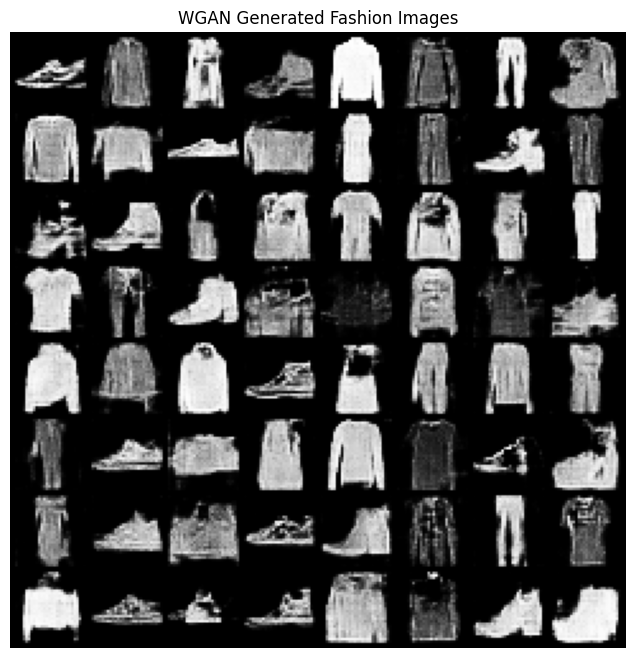

In [4]:
with torch.no_grad():
    fake = gen(fixed_noise).detach().cpu()
    
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("WGAN Generated Fashion Images")
plt.imshow(np.transpose(vutils.make_grid(fake, padding=2, normalize=True), (1,2,0)))
plt.show()

### Conclusion

**Why is this better?**


Look at the loss values printed during training. In a standard GAN, the discriminator loss usually goes to 0 (perfect classification) and the generator loss explodes. In WGAN, the loss values are actually meaningful distances. If the loss goes down, the image quality is likely improving.

WGAN-GP allows us to train deeper and more complex architectures without the hyperparameter headaches of standard GANs.